In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
%load_ext autoreload

In [3]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

2022-04-25 20:34:00.895552: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [4]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import load
import glob
import sys
import json
import time
from PIL import Image, ImageDraw
from pathlib import Path
import os
import shutil
import re
import zipfile

import matplotlib.pyplot as plt
import cv2

import numpy as np
import pickle
from tqdm import tqdm

import io
import base64
from IPython.display import HTML

In [5]:
# Loss Function and coefficients to be used during training:
def dice_coe(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

In [6]:
def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

In [7]:
activation = 'softmax'#'sigmoid'
patch_size_x =128 
patch_size_y =128 
n_classes = 33#1
channels=3

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization
import tensorflow as tf

def Unet2D(inputs,num_classes):
    x=inputs
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same',data_format="channels_last")(x)
    conv1= BatchNormalization()(conv1)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv1)
    conv1= BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same')(pool1)
    conv2= BatchNormalization()(conv2)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv2)
    conv2= BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool2)
    conv3= BatchNormalization()(conv3)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv3)
    conv3= BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool3)
    conv4= BatchNormalization()(conv4)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv4)
    conv4= BatchNormalization()(conv4)
    drop4 = Dropout(0.01)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool4)
    conv5= BatchNormalization()(conv5)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv5)
    conv5= BatchNormalization()(conv5)
    drop5 = Dropout(0.01)(conv5)
    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    up6= BatchNormalization()(up6)
    merge6 = concatenate([drop4,up6],axis=-1)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge6)
    conv6= BatchNormalization()(conv6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv6)
    conv6= BatchNormalization()(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    up7= BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=-1)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge7)
    conv7= BatchNormalization()(conv7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv7)
    conv7= BatchNormalization()(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    up8= BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=-1)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same')(merge8)
    conv8= BatchNormalization()(conv8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv8)
    conv8= BatchNormalization()(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    up9= BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=-1)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same')(merge9)
    conv9= BatchNormalization()(conv9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv9)
    conv9= BatchNormalization()(conv9)
#     conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)
    conv10 = Conv2D(num_classes, 1, activation = 'softmax')(conv9)
    model = Model(inputs=inputs, outputs = conv10)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [9]:
inputs = tf.keras.Input(shape=(patch_size_x,patch_size_y, channels))
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2"]) 

# with mirrored_strategy.scope():
Model_2D = Unet2D(inputs,num_classes=n_classes)
Model_2D.compile(optimizer=optim, loss=dice_loss, metrics=[dice_coe])
Model_2D.summary()

2022-04-25 20:34:05.959665: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-25 20:34:05.980349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 20:34:05.981756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-25 20:34:05.981792: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-25 20:34:05.984866: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-25 20:34:05.987997: I tensorflow/stream_executor/platfo

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from PIL import Image



def parse_image(img_path, image_size):
    image_rgb = cv2.resize(np.load(img_path), (128,128))
#     print(img_path)
#     train_img=np.expand_dims(image_rgb, axis=2)
    train_img = image_rgb.copy()
#     train_img = np.stack((image_rgb,)*3, axis=-1)
    return train_img

def parse_mask(mask_path, image_size):
    mask = np.load(mask_path)
    nm=np.zeros([128, 128, 33], dtype = int)
    for i in range(33):
        temp= mask[:,:,i].astype('float32')
        temp= cv2.resize(temp, (128, 128))
        nm[:,:,i]=temp
    train_mask= nm.copy()
#     np.shape(nm)
#     mask = np.where(mask==0,mask,1)
#     train_mask = np.expand_dims(mask, axis=2)
    return train_mask


class DataGen(Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size
        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            # Read image and mask
            image = parse_image(images_path[i], self.image_size)
            mask = parse_mask(masks_path[i], self.image_size)

            images_batch.append(image)
#             mask=np.where(mask>1,1,mask)
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [11]:
train_data_paths = sorted(glob.glob("/home/centos/rabeea/maski/images/*.npy"))#[0:25]
train_masks_paths = sorted(glob.glob("/home/centos/rabeea/maski/masks/*.npy"))#[0:25]



valid_data_paths = sorted(glob.glob("/home/centos/rabeea/maski/images/*.npy"))[25:30]
valid_masks_paths = sorted(glob.glob("/home/centos/rabeea/maski/masks/*.npy"))[25:30]

In [12]:
image_size = 128
batch_size = 1

epochs = 100

train_steps = len(train_data_paths)//batch_size
valid_steps = len(valid_data_paths)//batch_size

## Generator
train_gen = DataGen(image_size, train_data_paths,train_masks_paths, batch_size=batch_size)
valid_gen = DataGen(image_size,valid_data_paths, valid_masks_paths, batch_size=batch_size)

In [13]:
train_gen.__getitem__(20)[0].shape

(1, 128, 128, 3)

In [14]:
train_gen.__getitem__(20)[1].shape

(1, 128, 128, 33)

In [15]:
history=Model_2D.fit(train_gen,
                            validation_data=valid_gen,epochs=500,shuffle=True
                              )

Epoch 1/500


2022-04-25 20:34:20.443177: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-04-25 20:34:22.896010: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


30/30 [==============================] - 60s 2s/step - loss: 0.9494 - dice_coe: 0.0506 - val_loss: 0.9475 - val_dice_coe: 0.0525
Epoch 2/500
30/30 [==============================] - 59s 2s/step - loss: 0.9453 - dice_coe: 0.0547 - val_loss: 0.9462 - val_dice_coe: 0.0538
Epoch 3/500
30/30 [==============================] - 59s 2s/step - loss: 0.9403 - dice_coe: 0.0597 - val_loss: 0.9455 - val_dice_coe: 0.0545
Epoch 4/500
30/30 [==============================] - 60s 2s/step - loss: 0.9331 - dice_coe: 0.0669 - val_loss: 0.9450 - val_dice_coe: 0.0550
Epoch 5/500
30/30 [==============================] - 59s 2s/step - loss: 0.9233 - dice_coe: 0.0767 - val_loss: 0.9444 - val_dice_coe: 0.0556
Epoch 6/500
30/30 [==============================] - 59s 2s/step - loss: 0.9104 - dice_coe: 0.0896 - val_loss: 0.9438 - val_dice_coe: 0.0562
Epoch 7/500
30/30 [==============================] - 60s 2s/step - loss: 0.8964 - dice_coe: 0.1036 - val_loss: 0.9434 - val_dice_coe: 0.0566
Epoch 8/500
30/30 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30/30 [==============================] - 59s 2s/step - loss: 0.2512 - dice_coe: 0.7488 - val_loss: 0.5075 - val_dice_coe: 0.4925
Epoch 324/500
30/30 [==============================] - 59s 2s/step - loss: 0.2489 - dice_coe: 0.7511 - val_loss: 0.5039 - val_dice_coe: 0.4961
Epoch 325/500
30/30 [==============================] - 59s 2s/step - loss: 0.2479 - dice_coe: 0.7521 - val_loss: 0.5013 - val_dice_coe: 0.4987
Epoch 326/500
30/30 [==============================] - 59s 2s/step - loss: 0.2479 - dice_coe: 0.7521 - val_loss: 0.5185 - val_dice_coe: 0.4815
Epoch 327/500
30/30 [==============================] - 59s 2s/step - loss: 0.2467 - dice_coe: 0.7533 - val_loss: 0.5001 - val_dice_coe: 0.4999
Epoch 328/500
30/30 [==============================] - 59s 2s/step - loss: 0.2459 - dice_coe: 0.7541 - val_loss: 0.5000 - val_dice_coe: 0.5000
Epoch 329/500
30/30 [==============================] - 59s 2s/step - loss: 0.2449 - dice_coe: 0.7551 - val_loss: 0.4868 - val_dice_coe: 0.5132
Epoch 330/500

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
Model_2D.save('/home/centos/rabeea/maski/2Dunet_teeth_500.h5')

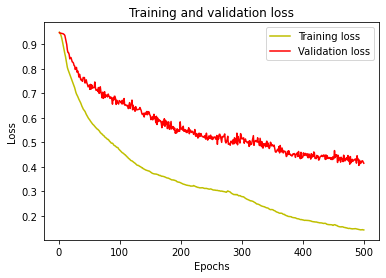

In [17]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

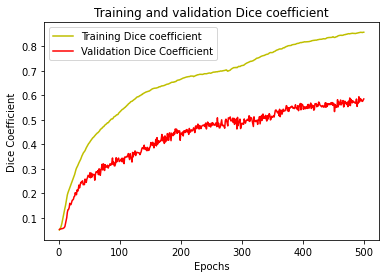

In [18]:
acc = history.history['dice_coe']
val_acc = history.history['val_dice_coe']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [52]:
y_pred=Model_2D.predict(train_gen.__getitem__(2)[0])
y_pred_argmax=np.where(y_pred>0.5,1,0)
true_msk=train_gen.__getitem__(2)[1]

In [53]:
np.unique(y_pred_argmax)

array([0, 1])

In [54]:
gt= np.zeros([128,128],dtype=int)
pred= np.zeros([128,128],dtype=int)
for i in range (33):
    gt= np.where(true_msk[0,:,:,i]==1,i,gt)
    pred= np.where(y_pred_argmax[0,:,:,i]==1,i,pred)

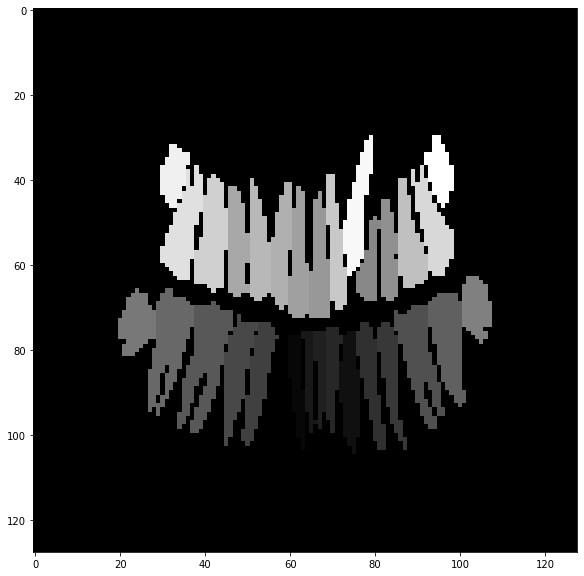

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(gt,'gray')
plt.show()

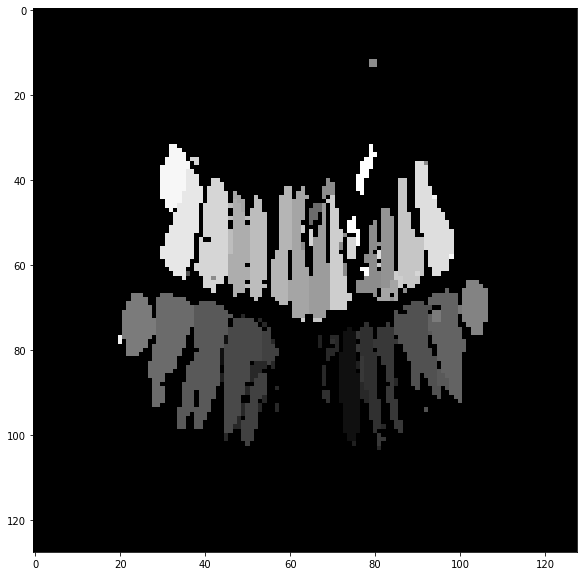

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(pred,'gray')
plt.show()

In [38]:
pred=pred.astype('float32')
pred= cv2.resize(pred, (1991, 1127))

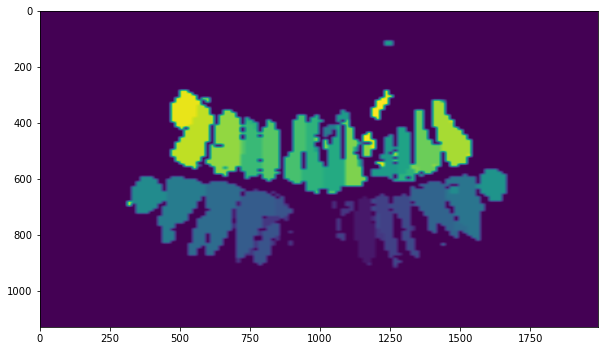

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(pred)
plt.show()

In [44]:
np.shape(train_gen.__getitem__(2)[0][0])

(128, 128, 3)

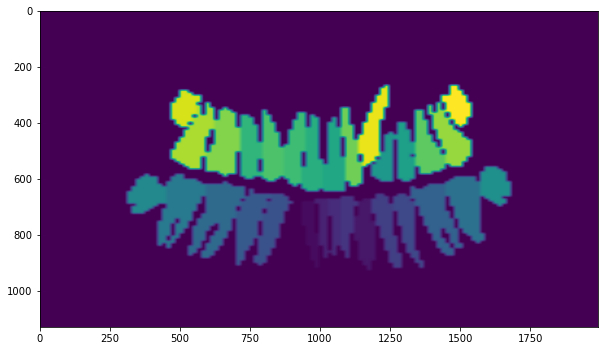

In [51]:
gt=gt.astype('float32')
gt= cv2.resize(gt, (1991, 1127))
original= cv2.resize(train_gen.__getitem__(2)[0][0].astype('float32'), (1991,1127))
plt.figure(figsize=(10,10))
# plt.imshow(original,alpha=0.5)
plt.imshow(gt)
plt.show()

In [46]:
np.unique(original)

array([  1.       ,   1.0003203,   1.000507 , ..., 224.75215  ,
       225.27463  , 226.77231  ], dtype=float32)

In [47]:
np.unique(gt)

array([0.0000000e+00, 2.2058925e-05, 4.0109644e-05, ..., 3.1989443e+01,
       3.1995832e+01, 3.2000000e+01], dtype=float32)